### How to run a jupyter notebook through a remote server on local machine:
https://stackoverflow.com/questions/69244218/how-to-run-a-jupyter-notebook-through-a-remote-server-on-local-machine

In [1]:
import sys

In [2]:
print("version:", sys.version)
print("environment:", sys.prefix)

version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]
environment: /home/aclexp/mambaforge/envs/quanta


In [3]:
import re

In [4]:
import os
import copy
import json
import numpy as np
import pandas as pd
from itertools import product

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
DF = pd.read_csv(os.path.join("rawdata", "DATA_ses-01_2024-12-09.csv"))
DF.rename(columns={"BASIC_INFO_ID": "ID"}, inplace=True)

inclusion_df = pd.read_csv(os.path.join("rawdata", "InclusionList_ses-01.csv"))
inclusion_df = inclusion_df.query("MRI == 1")

DF = pd.merge(DF, inclusion_df[["ID"]], on="ID", how='inner')

In [8]:
DF.drop(columns=[
    col for col in DF.columns 
    if ( "RESTING" in col )
    or ( col.startswith("LANGUAGE_SPEECHCOMP_BEH") and col.endswith("RT") )
    or ( col.startswith("MOTOR_GOFITTS_EEG") and (("Diff" in col) or ("Slope" in col)) )
    or ( col.startswith("MEMORY_EXCLUSION_BEH") and any( kw in col for kw in ["TarMiss", "NewFA", "NonTarFA_PROPORTION", "C2NonTarFA_RT", "C3NonTarFA_RT", "C1NewCR_PROPORTION", "C1NewCR_RTvar"] ) )
    or ( col.startswith("MEMORY_EXCLUSION_EEG") and any( kw in col for kw in ["TarHitNewCRdiff", "NonTarCRNewCRdiff"] ) )
    or ( col.startswith("MEMORY_OSPAN_EEG") and any( kw in col for kw in ["150To350", "AMPLITUDE"] ) )
    or ( col.startswith("MEMORY_MST_MRI") and any( kw in col for kw in ["OldCorSimCorDiff", "OldCorNewCorDiff", "SimCorNewCorDiff", "MD"] ) )
], inplace=True)

DF.drop(columns=[
    "MEMORY_OSPAN_EEG_MathItem01_PZ_250To450_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_PZ_250To450_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_PZ_250To450_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem01_PZ_400To600_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_PZ_400To600_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_PZ_400To600_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem01_O1_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_O1_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_O1_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem01_O2_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_O2_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_O2_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem01_OZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_OZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_OZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem01_PZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_PZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_PZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem2301Diff_O1_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem2301Diff_O2_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem2301Diff_OZ_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem45601Diff_O1_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem45601Diff_O2_600To800_4To8_POWER", 
    "MEMORY_OSPAN_EEG_MathItem01_PZ_1200To1400_20To25_POWER", 
    "MEMORY_OSPAN_EEG_MathItem23_PZ_1200To1400_20To25_POWER", 
    "MEMORY_OSPAN_EEG_MathItem456_PZ_1200To1400_20To25_POWER"
], inplace=True)

for col in DF.columns:
    if re.match(r"MOTOR_GFORCE_MRI_.*?HighForce_.*?H_.*?_[a-zA-Z]+", col):
        pair = col.replace("High", "Low")
        DF.insert(
            DF.columns.get_loc(col), 
            col.replace("High", "Mean"), 
            DF[[col, pair]].mean(axis=1)
        )
        DF.drop(
            columns=[col, pair], 
            inplace=True
        )

## Select features by specified domains and approaches

In [9]:
included_features = [ 
    col for col in DF.columns
    if any( domain in col for domain in ["STRUCTURE", "MOTOR", "MEMORY", "LANGUAGE"] )
    and any( approach in col for approach in ["MRI", "BEH", "EEG"] )
]

In [10]:
X = DF.loc[:, included_features]

In [11]:
len(X.columns)

1148

In [12]:
# cat_f = categorize_features(X.columns)

# for f in sorted(cat_f.keys()):
#     print(f"# {f}: {len(cat_f[f])}")

## Remove features with too many missing values

In [13]:
n_subjs = len(X)
na_rates = pd.Series(X.isnull().sum() / n_subjs)

Q1 = na_rates.quantile(.25)
Q3 = na_rates.quantile(.75)
IQR = Q3 - Q1
outliers = na_rates[na_rates > (Q3 + IQR * 1.5)]

print(
    f"{len(outliers)} out of {len(na_rates)} features have too many missing values (> {round(Q3 + IQR * 1.5, 2)})."
)

105 out of 1148 features have too many missing values (> 0.11).


[]

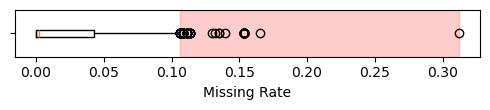

In [14]:
fig, ax = plt.subplots(figsize=(5, 1.2))
ax.boxplot(na_rates, vert=False)
ax.axvspan(Q3 + IQR * 1.5, na_rates.max(), color='r', alpha=0.2)
ax.set_xlabel("Missing Rate")
ax.set_yticklabels("")
plt.tight_layout()
plt.plot()
# plt.savefig(os.path.join("derivatives", "na_rates_boxplot.png"))

In [15]:
outliers

STRUCTURE_NULL_MRI_NULL_RIGHT_VESSEL_FA       0.312057
STRUCTURE_NULL_MRI_GM_LEFT_FrontalPole_FA     0.130024
STRUCTURE_NULL_MRI_GM_RIGHT_FrontalPole_FA    0.132388
STRUCTURE_NULL_MRI_WM_LEFT_ENTORHINAL_FA      0.106383
STRUCTURE_NULL_MRI_WM_LEFT_FUSIFORM_FA        0.106383
                                                ...   
MEMORY_MST_MRI_SimCor_RIGHT_FIorb_BETA        0.153664
MEMORY_MST_MRI_SimCor_RIGHT_FItri_BETA        0.153664
MEMORY_MST_MRI_SimCor_RIGHT_FM_BETA           0.153664
MEMORY_MST_MRI_SimCor_RIGHT_HP_BETA           0.153664
MEMORY_MST_MRI_SimCor_RIGHT_PI_BETA           0.153664
Length: 105, dtype: float64

In [16]:
X_cleaned = X.drop(columns=outliers.index)

In [17]:
len(X_cleaned.columns)

1043

## Fill missing values with median and standardize features

In [18]:
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X_cleaned), columns=X_cleaned.columns)

In [19]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

## Calculate VIF 
##### See: https://stats.stackexchange.com/questions/461141/is-it-advisable-to-impute-missing-values-and-scale-features-before-computing-the
##### Also: https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python

In [20]:
# def variance_inflation_factor(X: np.ndarray, idx: int):
#     mask = np.arange(X.shape[1]) != idx
#     X_i = X[:, idx]
#     X_else = X[:, mask]
#     reg = LinearRegression(fit_intercept=True).fit(X_else, X_i)
#     Xi_pred = reg.predict(X_else)
#     R_sq = reg.score(X_else, X_i)
#     # ss_tot = np.sum((X_i - np.mean(X_i)) ** 2)
#     # ss_res = np.sum((X_i - Xi_pred) ** 2)
#     # R_sq = 1 - (ss_res / ss_tot)
#     vif = 1 / max(1 - R_sq, 1e-16)
#     return vif

In [21]:
# vif_values = pd.Series(
#     [ variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1]) ], 
#     index=X_scaled.columns, 
#     name='VIF'
# )

In [22]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant

In [23]:
# X_ = add_constant(X_scaled)
# vif_values = pd.Series(
#     [ variance_inflation_factor(X_.values, i) for i in range(X_.shape[1]) ], 
#     index=X_.columns
# )

In [24]:
# vifs = pd.Series(
#     np.linalg.inv(X_scaled.corr().to_numpy()).diagonal(), # pseudo-inverse
#     index=X_scaled.columns, 
#     name='VIF'
# )

In [25]:
# vifs = vifs.sort_values(by="VIF", ascending=False)

In [26]:
# vifs[vifs.abs() < 5]

## Correlation matrix

In [27]:
# X_cormat = X_scaled.corr()
# X_corr = X_cormat.stack().reset_index()
# X_corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
# print(X_corr.describe().round(3))

In [28]:
# (X_corr['CORRELATION'] > .8).sum() / len(X_corr)

In [29]:
# X_cormat.to_csv(os.path.join("derivatives", "Feature cormat.csv"))

In [30]:
# sns.heatmap(X_cormat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

## Categorize features based on knowledge

In [31]:
categorized_GM_features = {
    "GySulFrontoMargin": "FT", # Fronto-marginal gyrus (of Wernicke) and sulcus
    "GySulSubCentral": "FT", # Subcentral gyrus (central operculum) and sulci
    "GySulTransvFrontopol": "FT", # Transverse frontopolar gyri and sulci
    "GyFrontInfOpercular": "FT", # Opercular part of the inferior frontal gyrus
    "GyFrontInfObital": "FT", # Orbital part of the inferior frontal gyrus
    "GyFrontInfTriangul": "FT", # Triangular part of the inferior frontal gyrus
    "GyFrontMiddle": "FT", # Middle frontal gyrus (F2)
    "GyFrontSup": "FT", # Superior frontal gyrus (F1)
    "GyOrbital": "FT", # Orbital gyri
    "GyRectus": "FT", # Straight gyrus, Gyrus rectus
    "LateralFisAnterorHorizont": "FT", # Horizontal ramus of the anterior segment of the lateral sulcus (or fissure)
    "LateralFisAnterorVertical": "FT", # Vertical ramus of the anterior segment of the lateral sulcus (or fissure)
    "LateralFisPost": "FT", # Posterior ramus (or segment) of the lateral sulcus (or fissure)
    "SulFrontInferior": "FT", # Inferior frontal sulcus
    "SulFrontMiddle": "FT", # Middle frontal sulcus
    "SulFrontSuperior": "FT", # Superior frontal sulcus
    "SulOrbitalLateral": "FT", # Lateral orbital sulcus
    "SulOrbitalMedialOlfact": "FT", # Medial orbital sulcus (olfactory sulcus)
    "SulOrbitalHshaped": "FT", # Orbital sulci (H-shaped sulci)
    "SulSubOrbital": "FT", # Suborbital sulcus (sulcus rostrales, supraorbital sulcus)
    "GyOccipitalTemporalLateralFusifor": "FT", # Lateral occipito-temporal gyrus (fusiform gyrus, O4-T4)
    "GyOccipitalTemporalMedialParahip": "FT", # Parahippocampal gyrus, parahippocampal part of the medial occipito-temporal gyrus, (T5)
    "GyTemporalSuperiorGyTemporalTransv": "FT", # Anterior transverse temporal gyrus (of Heschl)
    "GyTemporalSuperiorLateral": "FT", # Lateral aspect of the superior temporal gyrus
    "GyTemporalSuperiorPlanPolar": "FT", # Planum polare of the superior temporal gyrus
    "GyTemporalSuperiorPlanTempo": "FT", # Planum temporale or temporal plane of the superior temporal gyrus
    "GyTemporalInferior": "FT", # Inferior temporal gyrus (T3)
    "GyTemporalMiddle": "FT", # Middle temporal gyrus (T2)
    "PoleTemporal": "FT", # Temporal pole
    "SulOccipitalTemporalLateral": "FT", # Lateral occipito-temporal sulcus
    "SulOccipitalTemporalMedialAndLingual": "FT", # Medial occipito-temporal sulcus (collateral sulcus) and lingual sulcus
    "SulTemporalInferior": "FT", # Inferior temporal sulcus
    "SulTemporalSuperior": "FT", # Superior temporal sulcus (parallel sulcus)
    "SulTemporalTransverse": "FT", # Transverse temporal sulcus
    "GySulCingulAnt": "IC", # Anterior part of the cingulate gyrus and sulcus (ACC)
    "GySulCingulMidAnt": "IC", # Middle-anterior part of the cingulate gyrus and sulcus (aMCC)
    "GySulCingulMidPost": "IC", # Middle-posterior part of the cingulate gyrus and sulcus (pMCC)
    "GyCingulPostDorsal": "IC", # Posterior-dorsal part of the cingulate gyrus (dPCC)
    "GyCingulPostVentral": "IC", # Posterior-ventral part of the cingulate gyrus (vPCC, isthmus of the cingulate gyrus)
    "GyInsularLongSulCentralInsular": "IC", # Long insular gyrus and central sulcus of the insula
    "GyInsularShort": "IC", # Short insular gyri
    "GySubcallosal": "IC", # Subcallosal area, subcallosal gyrus
    "SulCircularInsulaAnteror": "IC", # Anterior segment of the circular sulcus of the insula
    "SulCircularInsulaInferior": "IC", # Inferior segment of the circular sulcus of the insula
    "SulCircularInsulaSuperoir": "IC", # Superior segment of the circular sulcus of the insula
    "SulPericallosal": "IC", # Pericallosal sulcus (S of corpus callosum)
    "GySulOccipitalInf": "PO", # Inferior occipital gyrus (O3) and sulcus
    "GyCuneus": "PO", # Cuneus (O6)
    "GyOccipitalMiddle": "PO", # Middle occipital gyrus (O2, lateral occipital gyrus)
    "GyOccipitalSup": "PO", # Superior occipital gyrus (O1)
    "GyOccipitalTemporalMedialLingual": "PO", # Lingual gyrus, ligual part of the medial occipito-temporal gyrus, (O5)
    "PoleOccipital": "PO", # Occipital pole
    "SulCalcarine": "PO", # Calcarine sulcus
    "SulCollatTransvAnterior": "PO", # Anterior transverse collateral sulcus
    "SulCollatTransvPosterior": "PO", # Posterior transverse collateral sulcus
    "SulOccipitalMiddleAndLunatus": "PO", # Middle occipital sulcus and lunatus sulcus
    "SulOccipitalSuperiorAndTransversal": "PO", # Superior occipital sulcus and transverse occipital sulcus
    "SulOccipitalAnterior": "PO", # Anterior occipital sulcus and preoccipital notch (temporo-occipital incisure)
    "SulParietoOccipital": "PO", # Parieto-occipital sulcus (or fissure)
    "GySulParaCentral": "PO", # Paracentral lobule and sulcus
    "GyParietalInfAngular": "PO", # Angular gyrus
    "GyParietalInfSupramar": "PO", # Supramarginal gyrus
    "GyParietalSuperior": "PO", # Superior parietal lobule
    "GyPostCentral": "PO", # Postcentral gyrus
    "GyPreCentral": "PO", # Precentral gyrus
    "GyPreCuneus": "PO", # Precuneus (medial part of P1)
    "SulCentral": "PO", # Central sulcus (Rolando's fissure)
    "SulCingulMarginalis": "PO", # Marginal branch (or part) of the cingulate sulcus
    "SulIntermPrimJensen": "PO", # Sulcus intermedius primus (of Jensen)
    "SulIntraParietAndParietalTrans": "PO", # Intraparietal sulcus (interparietal sulcus) and transverse parietal sulci
    "SulPostCentral": "PO", # Postcentral sulcus
    "SulPreCentralInferiorPart": "PO", # Inferior part of the precentral sulcus
    "SulPreCentralSuperiorPart": "PO", # Superior part of the precentral sulcus
    "SulSubParietal": "PO" # Subparietal sulcus
}

In [32]:
lower_categorized_GM = {
    k.lower(): v
    for k, v in categorized_GM_features.items()
}

In [33]:
def categorize_features(included_features):
    categorized_features = {}
    
    for feature in included_features:
        if feature.startswith("STRUCTURE"):
            category, hemi, area, measure = feature.split("_")[3::]
            if category == "NULL":
                f = f"STR ({category}, {measure})"
            else:
                if (category == "GM") and (measure != "FA"): 
                    region = lower_categorized_GM[area.lower()]
                    
                    if region == "IC":
                        f = f"STR ({category}, {region}, {measure})"
                    else:
                        f = f"STR ({category}, {hemi[0]}, {region}, {measure})"
                else:
                    f = f"STR ({category}, {hemi[0]}, {measure})"
        else:
            domain, task, measure, condition = feature.split("_")[:4]
            measure = "fMRI" if measure == "MRI" else measure                

            if domain == "LANGUAGE":
                f = f"{measure} ({domain.lower()})"
                
            elif (measure == "EEG") and (task == "OSPAN") and ("Diff" in condition):
                f = f"{measure} ({domain.lower()}, {task.lower()} diff)"
                
            elif (measure == "EEG") and (task == "GOFITTS"):
                suffix = re.sub(r"[0-9]+", "", condition).replace("ID", "").replace("W", "").replace("Slope", " slope")
                f = f"{measure} ({domain.lower()}, {task.lower()} {suffix.lower()})"
            
            else:
                f = f"{measure} ({domain.lower()}, {task.lower()})"

        if f in categorized_features.keys():
            categorized_features[f].append(feature)
        else:
            categorized_features.update({f: [feature]})
    
    return categorized_features

In [34]:
categorized_features = categorize_features(X_cleaned.columns)

In [35]:
ALL = True
# ALL = False 

t = 0
for f in sorted(categorized_features.keys()):
    c = len(categorized_features[f])
    if (c > 36) or ALL:
        print(f"# {f}: {c}")
        t += c
        
print("\n", t, "\n", len(categorized_features.keys()))

# BEH (language): 14
# BEH (memory, exclusion): 33
# BEH (memory, mst): 33
# BEH (memory, ospan): 20
# BEH (motor, bilpress): 6
# BEH (motor, gforce): 16
# BEH (motor, gofitts): 24
# EEG (memory, exclusion): 36
# EEG (memory, ospan diff): 35
# EEG (memory, ospan): 39
# EEG (motor, bilpress): 32
# EEG (motor, gofitts cue): 48
# EEG (motor, gofitts go): 48
# STR (GM, IC, ThickAvg): 24
# STR (GM, IC, ThickStd): 24
# STR (GM, IC, VOLUME): 24
# STR (GM, L, FA): 33
# STR (GM, L, FT, ThickAvg): 34
# STR (GM, L, FT, ThickStd): 34
# STR (GM, L, FT, VOLUME): 34
# STR (GM, L, PO, ThickAvg): 28
# STR (GM, L, PO, ThickStd): 28
# STR (GM, L, PO, VOLUME): 28
# STR (GM, R, FA): 33
# STR (GM, R, FT, ThickAvg): 34
# STR (GM, R, FT, ThickStd): 34
# STR (GM, R, FT, VOLUME): 34
# STR (GM, R, PO, ThickAvg): 28
# STR (GM, R, PO, ThickStd): 28
# STR (GM, R, PO, VOLUME): 28
# STR (NULL, FA): 36
# STR (WM, L, FA): 13
# STR (WM, L, VOLUME): 34
# STR (WM, R, VOLUME): 34
# fMRI (motor, gforce): 32

 1043 
 35


In [36]:
np.array([ len(v) for v in categorized_features.values() ]).sum()

1043

In [37]:
categorized_outliers = categorize_features(outliers.index)

for f in sorted(categorized_outliers.keys()):
    print(f"# {f}: {len(categorized_outliers[f])}")

# BEH (memory, mst): 2
# STR (GM, L, FA): 1
# STR (GM, R, FA): 1
# STR (NULL, FA): 1
# STR (WM, L, FA): 21
# STR (WM, R, FA): 34
# fMRI (memory, mst): 45


In [38]:
X_splited = {}
for f in categorized_features.keys():
    X_splited[f] = X_scaled.loc[:, categorized_features[f]]

## Combining variables using PCA 

In [39]:
## https://stackoverflow.com/questions/62303782/is-there-a-way-to-conduct-a-parallel-analysis-in-python
## https://www.statstodo.com/ParallelAnalysis.php

def parallel_analysis(X, n_iter=100, seed=42):
    n_components = X.shape[1] - 1
    pca = PCA(n_components, random_state=seed)
    X_transformed = pca.fit_transform(X)
    eigenvalues = pca.explained_variance_ratio_

    random_eigenvalues = np.zeros(shape=(n_iter, n_components))
    for i in range(n_iter): # Monte Carlo simulation
        X_r = np.random.normal(loc=0, scale=1, size=X.shape) # random data
        pca_r = PCA(n_components, random_state=42)
        X_r_transformed = pca_r.fit_transform(X_r)
        random_eigenvalues[i, :] = pca_r.explained_variance_ratio_
    
    rand_eigv_mean = random_eigenvalues.mean(axis=0)
    rand_eigv_std = random_eigenvalues.std(axis=0)
    thresholds = rand_eigv_mean + rand_eigv_std * 1.64 # the 95th percentile
    n_retained = max(np.argwhere(eigenvalues > thresholds)) + 1

    return n_retained, eigenvalues, random_eigenvalues

In [40]:
def remove_highly_correlated_features(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_cormat = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [ column for column in upper_cormat.columns if any(upper_cormat[column] > threshold) ]
    return X.drop(columns=to_drop), to_drop

In [41]:
dropped_features = {}
n_retained_comps = {}

for f, X_n in X_splited.items():
    X_n, dropped_features[f] = remove_highly_correlated_features(X_n)    
    n_components, eigv_raw, eigv_rand = parallel_analysis(X_n)
    n_retained_comps[f] = n_components[0]

In [47]:
t = 0
for f in sorted(n_retained_comps.keys()):
    c = n_retained_comps[f]
    print(f"# {f}: {c} [{len(dropped_features[f])}]")
    t += c

print("\n", t)

# BEH (language): 3 [3]
# BEH (memory, exclusion): 5 [0]
# BEH (memory, mst): 4 [14]
# BEH (memory, ospan): 3 [7]
# BEH (motor, bilpress): 2 [0]
# BEH (motor, gforce): 3 [0]
# BEH (motor, gofitts): 4 [2]
# EEG (memory, exclusion): 8 [0]
# EEG (memory, ospan diff): 6 [0]
# EEG (memory, ospan): 6 [0]
# EEG (motor, bilpress): 5 [3]
# EEG (motor, gofitts cue): 5 [0]
# EEG (motor, gofitts go): 4 [4]
# STR (GM, IC, ThickAvg): 4 [0]
# STR (GM, IC, ThickStd): 3 [0]
# STR (GM, IC, VOLUME): 1 [0]
# STR (GM, L, FA): 4 [1]
# STR (GM, L, FT, ThickAvg): 3 [0]
# STR (GM, L, FT, ThickStd): 2 [0]
# STR (GM, L, FT, VOLUME): 1 [0]
# STR (GM, L, PO, ThickAvg): 3 [0]
# STR (GM, L, PO, ThickStd): 2 [0]
# STR (GM, L, PO, VOLUME): 3 [0]
# STR (GM, R, FA): 4 [1]
# STR (GM, R, FT, ThickAvg): 3 [0]
# STR (GM, R, FT, ThickStd): 3 [0]
# STR (GM, R, FT, VOLUME): 3 [0]
# STR (GM, R, PO, ThickAvg): 3 [0]
# STR (GM, R, PO, ThickStd): 2 [0]
# STR (GM, R, PO, VOLUME): 2 [0]
# STR (NULL, FA): 4 [1]
# STR (WM, L, FA): 1 [

## Else

##### Mundfrom, D. J., Shaw, D. G., & Ke, T. L. (2005). Minimum sample size recommendations for conducting factor analyses. https://doi.org/10.1207/s15327574ijt0502_4

In [43]:
sub_DF_list = [
    DF[DF["BASIC_INFO_AGE"].between(lb, ub)] for lb, ub in [(0, 44), (45, np.inf)]
]

print(len(DF) / 5)

for sub_DF in sub_DF_list:
    print(round(len(sub_DF), 2), "-> /5 ->", round(len(sub_DF) / 5, 2))
    print(round(len(sub_DF) * 0.7, 2), "-> *.7/5 > ", round(len(sub_DF) *0.7 / 5, 2))

84.6
180 -> /5 -> 36.0
126.0 -> *.7/5 >  25.2
243 -> /5 -> 48.6
170.1 -> *.7/5 >  34.02


In [48]:
with open(os.path.join("outputs", "train_and_test_ids.json"), 'r') as f:
    split_with_ids = json.load(f)

testset_ratio = (
    len(split_with_ids["Test"]) / (len(split_with_ids["Train"]) + len(split_with_ids["Test"]))
)

In [49]:
for sub_DF in sub_DF_list:
    print(
        len([ x for x in split_with_ids["Train"] if x in sub_DF["ID"].values ]), 
        len([ x for x in split_with_ids["Test"] if x in sub_DF["ID"].values ])
    )

126 54
169 74


In [ ]:
print(126 / 5)
print(169 / 5)

In [ ]:
# set([ "_".join(f.split("_")[:3]) for f in DF.columns ])

## Check outputs

In [ ]:
import pickle
from age_pred_model import FeatureReducer
from factor_analyzer import Rotator

In [50]:
out_dir = os.path.join("outputs", "2025-08-13_original_sex-0")

In [ ]:
group_name = ["le-44", "ge-45"][0]
ori_name = ["STRUCTURE", "BEH", "FUNCTIONAL", "ALL"][-1]

reducer_path = os.path.join(out_dir, "reducer_{}_{}.pkl".format(group_name, ori_name))
# pc_loadings_path = os.path.join(out_dir, "PC_loadings_{}_{}.xlsx".format(group_name, ori_name))
# rc_loadings_path = os.path.join(out_dir, "RC_loadings_{}_{}.xlsx".format(group_name, ori_name))

In [ ]:
with open(reducer_path, 'rb') as f:
    reducer = pickle.load(f)

In [ ]:
# for f in reducer.fitted_pca.keys():
#     eigenvectors = reducer.fitted_pca[f].components_.T
#     # print(np.linalg.norm(eigenvectors, axis=0))

#     eigenvalues = reducer.fitted_pca[f].explained_variance_
#     loadings = eigenvectors * np.sqrt(eigenvalues)

#     if loadings.shape[1] > 1: # Apply varimax rotation
#         rotator = Rotator(method="varimax")
#         rotated_loadings = rotator.fit_transform(np.array(loadings))
#         rotated_scores = np.linalg.pinv(rotated_loadings.T)
#         print(np.linalg.norm(rotated_scores, axis=0))

In [ ]:
# for f in reducer.rotated_components.keys():
#     print(np.linalg.norm(reducer.rotated_components[f], axis=0))

In [68]:
group_name = ["le-44", "ge-45"][0]
ori_name = ["STRUCTURE", "BEH", "FUNCTIONAL", "ALL"][-1]

feature_importances = pd.read_csv(
    os.path.join(out_dir, "features_{}_{}.csv".format(group_name, ori_name)), 
    header=None
)
feature_importances.sort_values(by=1, ascending=False, key=abs, inplace=True)

In [70]:
6 / 20 

0.3

In [59]:
len(feature_importances)

# 20 6
# 40 12
# 100 30

42

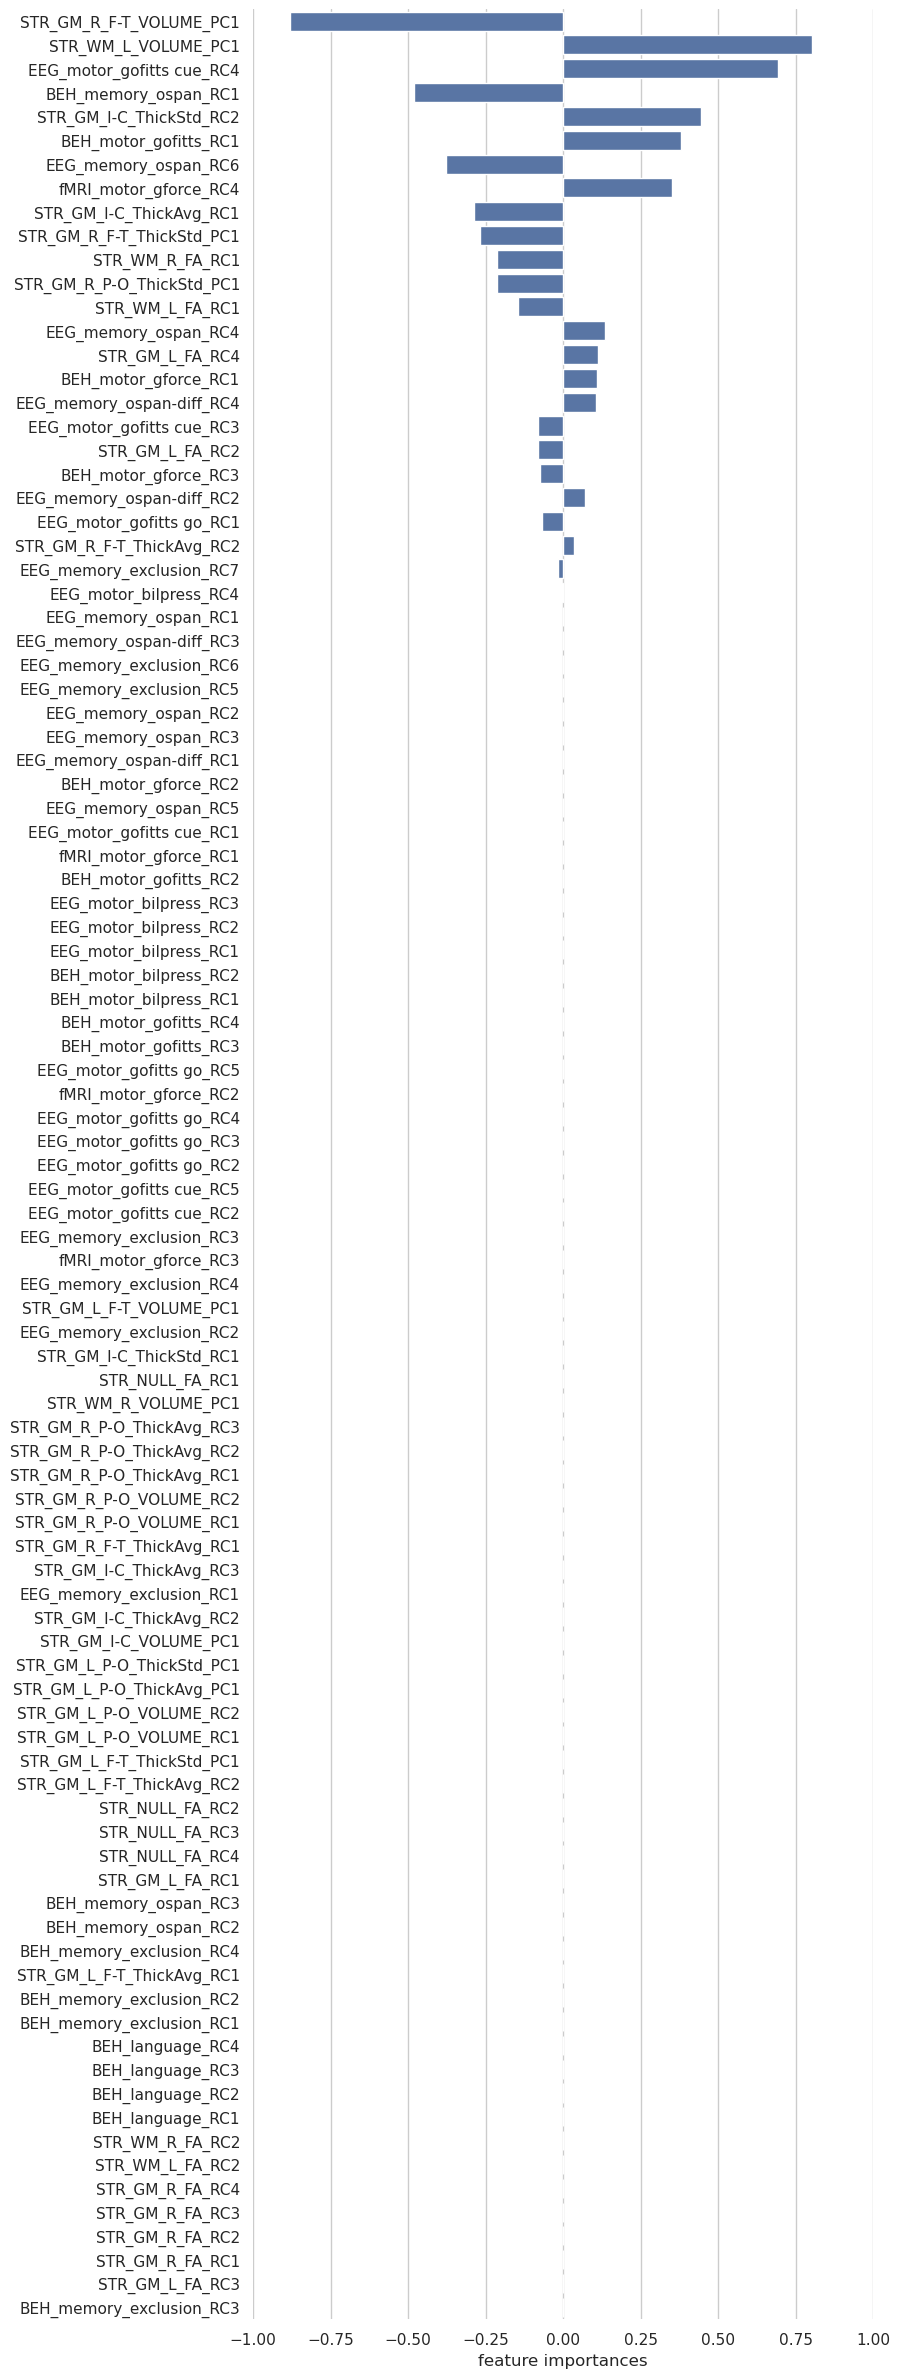

In [69]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 30))
sns.barplot(x=1, y=0, data=feature_importances)
ax.set(xlim=(-1, 1), 
       ylabel="",
       xlabel="feature importances")
sns.despine(left=True, bottom=True)